# Importe as bibliotecas necessárias

In [ ]:
'''
# Instalando as bibliotecas necessárias
%pip install -U pip setuptools wheel
%pip install pymongo
%pip install pandas
%pip install nltk
%pip install wordcloud
%pip install spacy
%pip install matplotlib
%pip install numpy==1.26.4
%pip install -U scikit-learn
%pip install unidecode
'''

# Importando as bibliotecas

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
from datetime import datetime
from db import connection_db as conndb
from db import filters
from utils import plot_graphs
from utils.text_treatment import TextTreatment
from utils.text_vectorization import TextVectorization
from dateutil.relativedelta import relativedelta

In [ ]:
mongo_connection = conndb.MongoDBConnection(uri='mongodb://localhost:27017/', database_name='dadosVivamente',
                                            collection_name='dadosSemFiltros')
mongo_connection.connect()
collection = mongo_connection.collection

In [ ]:
collection_filters = filters.CollectionFilters(collection)
collection_filters.apply_pipeline1('dadosComFiltrosIniciais')
collection_filters.apply_pipeline2(7, 2, 'posts7anos2anos')
collection_filters.apply_pipeline3('postsComBDIAndInfos')
collection_filters.apply_pipeline4('postsComBDIAndInfosFiltroDataPosts')
data_inicio = datetime(2017, 12, 1)
data_fim = data_inicio - relativedelta(months=6)
collection_filters.apply_pipeline5('postsFiltradosPorData', data_inicio, data_fim)
collection_filters.quant_users_cat('suicida', '$eq', '3')
collection_filters.count_users_by_gender('suicida', '$eq', '3', 'M')
collection_filters.count_users_by_gender('suicida', '$eq', '3', 'F')
collection = collection_filters.collection

In [ ]:
# Filtrando documentos com o atributo maior que 3
filtro = {"suicida": {"$eq": "3"}}
documentos = collection.find(filtro)

In [ ]:
# Transformando os documentos em um DataFrame
df = pd.DataFrame(list(documentos))
df.head()

In [ ]:
print(df.dtypes)
# Lista de colunas que precisam ser convertidas
colunas_para_converter = [
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima',
    'critica', 'suicida', 'choro', 'agitacao', 'interesse', 'indecisao',
    'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'quantAmigos'
]

df[colunas_para_converter] = df[colunas_para_converter].astype('int64')

In [ ]:
# Salvar o DataFrame em um arquivo CSV
df.to_csv('dados/com_filtros_datas/6meses/so_suicida_6_meses.csv', index=False)

In [ ]:
# Agrupar por usuário, mês e ano
posts_grouped = df.groupby(['id_usuario', 'mes', 'ano']).size().reset_index(name='quantidade')

# Adicionar coluna com o período e converter para datetime
posts_grouped['periodo'] = pd.to_datetime(posts_grouped['mes'].astype(str) + '/' + posts_grouped['ano'].astype(str),
                                          format='%m/%Y')

# Deve retornar 0 se a conversão foi bem-sucedida.
print(posts_grouped['periodo'].isnull().sum())

posts_grouped.dtypes

# Plotar quantidade de posts por usuário

In [ ]:
plot_graphs.PlotGraphs().plot_posts_per_user(posts_grouped, 'dados/com_filtros_datas/6meses/graficos')

# Efentuando a limpeza dos dados

In [ ]:
df['postMessageLimpo'] = df['postMessage'].fillna('').apply(
    lambda text: TextTreatment(text).preprocessamento_texto() if text else '')

In [ ]:
# Exibir apenas as colunas postMessage e postMessageLimpo
df[['postMessage', 'postMessageLimpo']].head()

In [ ]:
# Carregar stopwords em português para os TF-IDF e Bag of Words
stop_words = stopwords.words('portuguese')

In [19]:
text_vectorizer = TextVectorization(df, stop_words)
# Vetorização TF-IDF
resultados_tfidf = text_vectorizer.tfidf_vectorization(
    'dados/com_filtros_datas/6meses/so_suicida_resultados_tfidf_unigramas.csv', 0.60, 2,
    (1, 1))

# Vetorização Bag of Words
resultados_bow = text_vectorizer.bag_of_words_vectorization('dados/com_filtros_datas/6meses/so_suicida_resultados_bow_unigramas.csv',
                                           0.85, 5, (1, 1))

           id_usuario  palavra     score
0    1870214326566563      amo  0.060729
1    1870214326566563    série  0.038462
2    1870214326566563  lindooo  0.038462
3    1870214326566563    cunha  0.032473
4    1870214326566563     pães  0.030600
..                ...      ...       ...
575  1942377509357721       ta  0.006532
576  1942377509357721   pessoa  0.006301
577  1942377509357721  aguento  0.006246
578  1942377509357721      dor  0.006175
579  1942377509357721     oque  0.005895

[580 rows x 3 columns]
           id_usuario palavra  contagem
0    1870214326566563     amo         3
1    1870214326566563     mês         1
2    1870214326566563     mãe         1
3    1870214326566563    foto         1
4    1870214326566563    mini         1
..                ...     ...       ...
575  1942377509357721   mundo         6
576  1942377509357721    hoje         6
577  1942377509357721  pessoa         6
578  1942377509357721     mim         6
579  1942377509357721     tão         6

[58

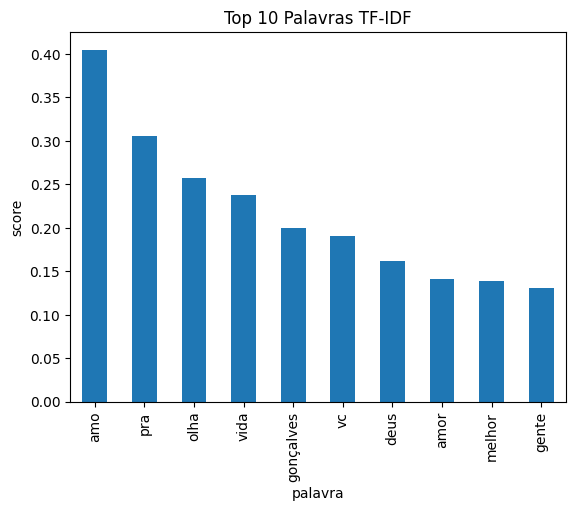

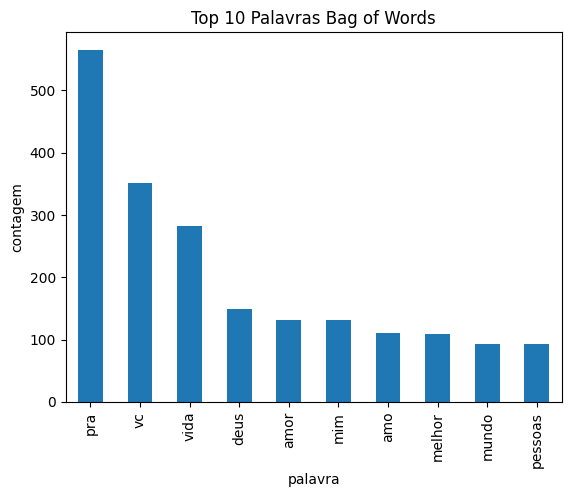

In [18]:
text_vectorizer.plot_top_words(resultados_tfidf, column='score', title='Top 10 Palavras TF-IDF')
text_vectorizer.plot_top_words(resultados_bow, column='contagem', title='Top 10 Palavras Bag of Words')